In [1]:
# Expected file structure
"""
├── airport
│   ├── airport_CapeTown_aerial.png
│   ├── airport_CapeTown.png
│   ├── airport_short.mp4
│   ├── airport_short.txt
│   ├── cams_info.mat
│   ├── images
│   │   ├── img_0001.jpg
            ...
│   │   └── img_0359.jpg
│   ├── kp_gmaps.mat
│   └── yolo
│       ├── yolo_0001.mat
            ...
│       └── yolo_0359.mat
├── airport.ipynb
"""

'\n├── airport\n│\xa0\xa0 ├── airport_CapeTown_aerial.png\n│\xa0\xa0 ├── airport_CapeTown.png\n│\xa0\xa0 ├── airport_short.mp4\n│\xa0\xa0 ├── airport_short.txt\n│\xa0\xa0 ├── cams_info.mat\n│\xa0\xa0 ├── images\n│\xa0\xa0 │\xa0\xa0 ├── img_0001.jpg\n            ...\n│\xa0\xa0 │\xa0\xa0 └── img_0359.jpg\n│\xa0\xa0 ├── kp_gmaps.mat\n│\xa0\xa0 └── yolo\n│\xa0\xa0     ├── yolo_0001.mat\n            ...\n│\xa0\xa0     └── yolo_0359.mat\n├── airport.ipynb\n'

In [2]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import json
import os

%load_ext autoreload
%autoreload 2

In [3]:
data_path = Path(os.getcwd()) / 'airport'

aerial_fpath = (data_path / './airport_CapeTown_aerial.png')
first_frame_fpath = (data_path / './airport_CapeTown.png')

yolo_fpaths = sorted((data_path / 'yolo').glob('*.mat'),
                     key=lambda x: int(x.stem.split('_')[1])
                    )

img_fpaths = sorted((data_path / 'images').glob('*.jpg'),
                     key=lambda x: int(x.stem.split('_')[1])
                    )

with open('yolo_classes.json', 'r') as file:
    yolo_classes = json.load(file)['class']


In [4]:
# Assert same number of images and yolo files
assert len(img_fpaths) == len(yolo_fpaths)

# Assert ordered images and yolo files
for i in range(len(img_fpaths)):
    assert img_fpaths[i].stem.split('_')[1] == yolo_fpaths[i].stem.split('_')[1]

In [5]:
aerial_img = np.array(Image.open(aerial_fpath))
aerial_img = aerial_img[:, :, :3].copy() # Remove alpha channel

In [6]:
import numpy as np
from scipy.ndimage import map_coordinates

def warpPerspective(img, H, output_shape):
    """
    Applies a homography matrix H to warp an image.
    
    Parameters:
        img (ndarray): Input image (H x W x C).
        H (ndarray): Homography matrix (3x3).
        output_shape (tuple): Desired shape of the output (height, width).
        
    Returns:
        warped_img (ndarray): The warped image.
    """
    # Create a grid of coordinates in the output image
    height, width = output_shape
    y, x = np.indices((height, width))
    coords = np.stack([x.ravel(), y.ravel(), np.ones_like(x.ravel())], axis=0)

    # Apply the inverse of the homography matrix to the output coordinates
    H_inv = np.linalg.inv(H)
    transformed_coords = H_inv @ coords
    transformed_coords /= transformed_coords[2]  # Normalize homogeneous coordinates
    
    x_src = transformed_coords[0].reshape(height, width)
    y_src = transformed_coords[1].reshape(height, width)

    # Map the coordinates from the source image
    warped_img = np.zeros((height, width, img.shape[2]), dtype=img.dtype)
    for i in range(img.shape[2]):  # For each color channel
        warped_img[:, :, i] = map_coordinates(img[:, :, i], [y_src, x_src], order=1, mode='constant', cval=0)

    return warped_img

In [7]:
def transform_yolo_coordinates(yolo_data, H):
    
    # Extract bounding box coordinates (assuming 'xyxy' is the key for bounding boxes)
    bounding_boxes = yolo_data['xyxy']
    
    # Transform the bounding box coordinates using the homography matrix
    transformed_bounding_boxes = []
    
    for bbox in bounding_boxes:
        x_min, y_min, x_max, y_max = bbox
        
        # Convert the bounding box corners to homogeneous coordinates (x, y, 1)
        # Apply the homography matrix to each corner
        points = np.array([[x_min, y_min, 1], [x_max, y_max, 1]])  # 2 corners, each in homogeneous coordinates
        
        # Apply the homography matrix to each corner (use matrix multiplication)
        transformed_points = np.dot(H, points.T).T  # Resulting transformed points (homogeneous coordinates)
        
        # Convert back to non-homogeneous coordinates (divide by the third coordinate)
        transformed_points = transformed_points[:, :2] / transformed_points[:, 2:3]  # Divide by the last column (w)
        
        # Get the transformed bounding box corners
        x_min_transformed, y_min_transformed = transformed_points[0]
        x_max_transformed, y_max_transformed = transformed_points[1]
        
        # Add the transformed bounding box to the list
        transformed_bounding_boxes.append([x_min_transformed, y_min_transformed, x_max_transformed, y_max_transformed])
    
    return np.array(transformed_bounding_boxes)


In [8]:
# Create a folder to save the files
homographies = "output_homographies"
os.makedirs(homographies, exist_ok=True)  # Create folder if it doesn't exist

# Create the output folder for the warped images
warped_images= "warped_images"
os.makedirs(warped_images, exist_ok=True)

# Create the output folder for the Transformed YOLO detections
Transformed_yolo = "transformed_yolo_bboxes"
os.makedirs(Transformed_yolo, exist_ok=True)

[[152.01659 228.8963  180.15756 206.96994]
 [430.35925 237.89246 457.54767 213.78455]
 [505.8695  321.155   552.302   284.05402]
 [374.3593  216.02876 397.26422 195.35988]
 [473.3334  352.      520.76855 323.1196 ]]
[[ 376.9259058   982.58806731  393.30853198  774.69818775]
 [ 536.57260171 1096.68783462  576.18421495  927.10725064]
 [ 516.70362434 1430.96345185  553.81957339 1321.17554989]
 [ 524.49218579  925.9308763   562.84618745  721.26334261]
 [ 494.82716427 1500.96866186  520.65058088 1436.05203629]]


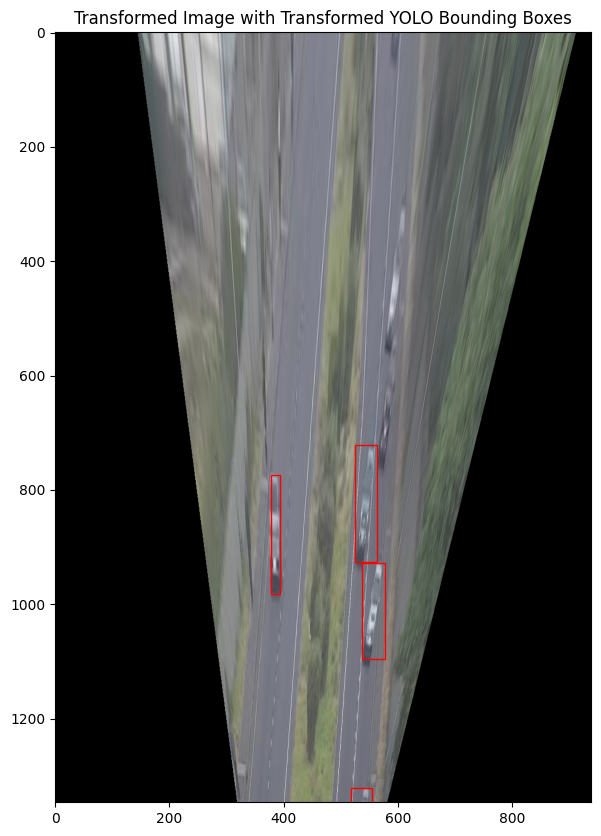

[[154.7275  227.10507 182.94176 205.68289]
 [431.86523 240.08095 459.73694 215.09814]
 [510.95584 327.53632 558.1626  287.7415 ]
 [375.37753 218.22171 398.35583 197.15146]
 [477.2972  351.29446 526.21045 328.65656]]
[[ 378.35152954  968.18724559  395.37378141  760.4983356 ]
 [ 535.5265931  1110.20435311  575.76987522  938.69230013]
 [ 515.5359387  1446.8478035   553.41218734 1334.08286623]
 [ 523.15858843  944.92305973  561.10942716  742.99967222]
 [ 496.23300164 1499.51310559  519.8781947  1449.6135724 ]]


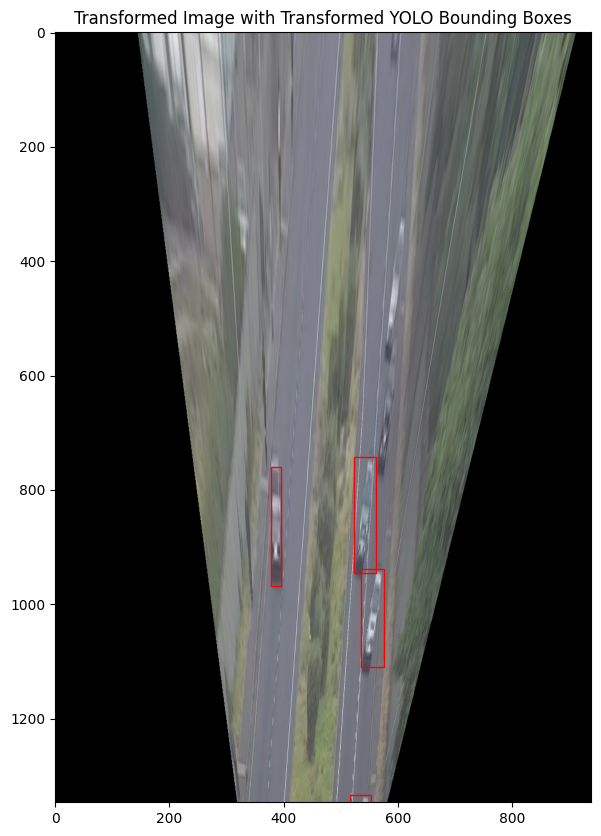

In [ ]:
import scipy.io as spio
from PIL import Image

for i in range(len(img_fpaths)):

    file_path = Path('kp_gmaps.mat')
    matches = sp.io.loadmat(data_path/file_path)['kp_gmaps']
    match_video = matches[i:,:2]
    match_maps = matches[i:,2:]

    A = []
    def compute_segment_A(x1, y1, x2, y2):
        return [
            [x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2, -x2],
            [0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2, -y2]
        ]

    for x_vid, y_vid, x_map, y_map in matches:
        A.extend(compute_segment_A(x_vid, y_vid, x_map, y_map))

    A = np.array(A)

    U, S, Vt = np.linalg.svd(A)
    # h is the last column of V
    H = Vt.T[:, -1].reshape(3, 3)

    H_inv = np.linalg.inv(H)


    # Save H and H_inv into .mat files
    output_index = i
    filename = os.path.join(homographies, f"output_{output_index:05d}.mat")  # e.g., output/output_00001.mat

    # Save to .mat file
    spio.savemat(filename, {'H': H})

    yolo_data = sp.io.loadmat(yolo_fpaths[i])
    frame_img = Image.open(img_fpaths[i])

    img = np.array(frame_img)

    # Define the homography matrix H and the output shape
    output_shape = (aerial_img.shape[0], aerial_img.shape[1])  # Define the size of the warped output
    warped_img = warpPerspective(img, H, output_shape)

    # Convert the warped image to a Pillow image for saving
    warped_img_pil = Image.fromarray(warped_img.astype(np.uint8))

    # Save the warped image as a .jpg file
    output_index = i  # Example index for the file naming
    filename = os.path.join(warped_images, f"output_{output_index:05d}.jpg")  # e.g., warped_images/output_00001.jpg

    # Save the image
    warped_img_pil.save(filename)

    transformed_bounding_boxes = transform_yolo_coordinates(yolo_data, H)

    # Create the structure to save in the .mat file
    bbox_dict = {'bbox': transformed_bounding_boxes}

    # Save the transformed bounding boxes to a .mat file
    filename = os.path.join(Transformed_yolo, f"yolooutput_{output_index:05d}.mat")
    spio.savemat(filename, bbox_dict)

    """ # Plot the transformed image with transformed bounding boxes
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(warped_img)

    # Plot each transformed bounding box
    for bbox in transformed_bounding_boxes:
        x_min, y_min, x_max, y_max = bbox
        width, height = x_max - x_min, y_max - y_min
        rect = plt.Rectangle((x_min, y_min), width, height, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    ax.set_title('Transformed Image with Transformed YOLO Bounding Boxes')
    plt.show() """

